In [11]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from NFconstants import N_nod, Beta, a, K_nod
from NFandist import get_O
from Data import normal_dist

def set_random_seed(seed):
    torch.manual_seed(seed)
    
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)

In [4]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split,
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1=torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 * torch.exp(s) + t
        log_det = s.sum(-1) 
        z[:,mask2]=x2
        return z, log_det


In [5]:
def get_split_masks(dim=N_nod):
    mask1=list(range(0,dim,2))
    mask2=list(range(1,dim,2))
    split_masks=[mask1,mask2]
    return split_masks
    

In [6]:
def get_pair_split_masks(dim=N_nod):
    mask1=list(range(0,dim,4))
    mask2=list(range(2,dim,4))
    mask1=(mask1+list(map(lambda x:x+1,mask1)))
    mask2=(mask2+list(map(lambda x:x+1,mask2)))
    mask1.sort()
    mask2.sort()
    split_masks=[mask1,mask2]
    return split_masks

In [7]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)
        
    def configure_theta(num_hidden,hidden_dim,p_drop,in_dim=N_nod//2,out_dim=N_nod//2):
        theta=ThetaNetwork(
                in_dim = in_dim,
                out_dim = out_dim,
                num_hidden = num_hidden,  #2 to 6
                hidden_dim = hidden_dim , #100-1024
                num_params = 2,
                p_drop=p_drop,
        )
        return theta    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x),negative_slope=0.01)
        for h in self.hidden:
            x = F.leaky_relu(h(x),negative_slope=0.01)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]

In [8]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], conv_flows = [], ort=False):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.conv_flows = conv_flows
        
    def configure_flows(n_flows,num_hidden,hidden_dim,p_drop,dim=N_nod,param_dim=0):  # n_flows=8,...,12
        flows = []
        split_masks_d = get_pair_split_masks(dim)
    
        for k in range(n_flows):
            theta = ThetaNetwork.configure_theta( num_hidden = num_hidden, hidden_dim = hidden_dim, p_drop=p_drop ,in_dim = dim//2+param_dim,out_dim = dim//2)
            flows.append(AffineCouplingLayer(theta,split=split_masks_d,swap=k%2))
   
        flows = nn.ModuleList(flows)
        return flows     

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        x, sum_log_abs_det = z, torch.zeros(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x,params)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x=torch.matmul(x,Ot.to(x.device))

        
        for flow in reversed(self.conv_flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    

In [9]:
class RGflows(nn.Module):
    
    def __init__(self,latent: Distribution ,nflist, masks, n_flows_dict,num_hidden_dict,hidden_dim_dict):
        super().__init__()
        self.latent = latent
        self.nflist = nflist
        self.masks = masks
        self.n_flows_dict = n_flows_dict
        self.num_hidden_dict = num_hidden_dict
        self.hidden_dim_dict = hidden_dim_dict
        
    def configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=0):  
        nflist=[]
        dim = len(masks[0])
        param_dim = 0
        for k in range(len(masks)):
            flows =  NormalizingFlow.configure_flows(n_flows = n_flows_dict[dim] , num_hidden = num_hidden_dict[dim] , hidden_dim = hidden_dim_dict[dim], dim = dim , param_dim = param_dim, p_drop = p_drop)
            nflist.append(NormalizingFlow(latent=normal_dist,flows=flows,ort=False))
            param_dim += dim 
            if k!=0: dim *= 2 
        nflist = nn.ModuleList(nflist)        
        return nflist    
        
    def configure_RG_model(latent,masks,n_flows_dict, num_hidden_dict,hidden_dim_dict,p_drop=0):
        flows=RGflows.configure_RG_flows(
            masks,
            n_flows_dict,
            num_hidden_dict,
            hidden_dim_dict,
            p_drop=p_drop)
        return RGflows(latent,flows,RGmasks,n_flows_dict,num_hidden_dict,hidden_dim_dict)
    
    def save(self,filename):
        state_dict = self.state_dict()
        model_dict={"state_dict":state_dict,
                    "n_flows_dict":self.n_flows_dict,
                    "num_hidden_dict":self.num_hidden_dict,
                    "hidden_dim_dict":self.hidden_dim_dict,
                    "masks":self.masks}
        torch.save(model_dict,filename)
    
    def load_model(filename):   
        model_dict = torch.load(filename,map_location = device)
        model=RGflows.configure_RG_model(normal_dist,
                                  model_dict["masks"],
                                  model_dict["n_flows_dict"], 
                                  model_dict["num_hidden_dict"],
                                  model_dict["hidden_dim_dict"],
                                  p_drop=0)
        model.load_state_dict(model_dict["state_dict"])
        return model
        

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params=torch.tensor([]).to(z.device)
        for i in range(len(self.nflist)):
            x=z[:,self.masks[i]]
            x, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params=torch.cat((params,x.detach()),dim=-1)
            z[:,self.masks[i]]=x
        z = torch.matmul(z,Ot.to(z.device))    
        return z, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def forward(self,z):
        with torch.no_grad():
            t=(z.clone()).to(z.device)
            x, log_abs_det=self.g(t)
            log_abs_det=log_abs_det.detach().to(z.device)
        return x, log_abs_det
    
 

    

In [10]:
def get_points(start,stop,step):
    if step == 0:
        print("step = 0 error")
        return 1
    x=start
    Y=[]
    while x < stop:
        Y.append(x)
        Y.append(x+1)
        x += step
    return Y


def config_RG_masks(m,n_nod):
    masks = []
    start = 0
    step = n_nod // (2 ** (m-1))
    tmp = get_points(start,n_nod,step)
    masks.append(tmp)
    if n_nod == 2 ** m:
        return masks
    start = step//2
    masks.append(get_points(start,n_nod,step))
    while step > 4:
        step //= 2
        start = step//2
        masks.append(get_points(start,n_nod,step))
    return masks
    

In [11]:
RGmasks = config_RG_masks(3,N_nod)

In [12]:
print(RGmasks)

[[0, 1, 64, 65, 128, 129, 192, 193], [32, 33, 96, 97, 160, 161, 224, 225], [16, 17, 48, 49, 80, 81, 112, 113, 144, 145, 176, 177, 208, 209, 240, 241], [8, 9, 24, 25, 40, 41, 56, 57, 72, 73, 88, 89, 104, 105, 120, 121, 136, 137, 152, 153, 168, 169, 184, 185, 200, 201, 216, 217, 232, 233, 248, 249], [4, 5, 12, 13, 20, 21, 28, 29, 36, 37, 44, 45, 52, 53, 60, 61, 68, 69, 76, 77, 84, 85, 92, 93, 100, 101, 108, 109, 116, 117, 124, 125, 132, 133, 140, 141, 148, 149, 156, 157, 164, 165, 172, 173, 180, 181, 188, 189, 196, 197, 204, 205, 212, 213, 220, 221, 228, 229, 236, 237, 244, 245, 252, 253], [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31, 34, 35, 38, 39, 42, 43, 46, 47, 50, 51, 54, 55, 58, 59, 62, 63, 66, 67, 70, 71, 74, 75, 78, 79, 82, 83, 86, 87, 90, 91, 94, 95, 98, 99, 102, 103, 106, 107, 110, 111, 114, 115, 118, 119, 122, 123, 126, 127, 130, 131, 134, 135, 138, 139, 142, 143, 146, 147, 150, 151, 154, 155, 158, 159, 162, 163, 166, 167, 170, 171, 174, 175, 178, 179, 182, 183

In [13]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.5,
            mode="min",
            threshold=0.1,
            patience = 1,
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [14]:
import time
class MCMC:
    def __init__(self,system,model="none",d=(a/N_nod)**0.5,N_sweep=100,log_per=1000):
        
        self.system = system
        self.S = 0
        self.model = model
        self.d = d
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.ar = 0
        self.shift_dist = torch.distributions.Uniform(torch.zeros(N_nod), torch.ones(N_nod))
        self.un = torch.distributions.Uniform(0, 1)
        self.res=[]
        self.times=[]
        
    def sweep(self,z):
        shift = self.shift_dist.sample((N_samp,)).to(z.device)
        y = z+self.d*(2*shift-1)
    
        S_new=self.calc_S(y)
    
        dS=S_new-self.S
        prob = torch.exp(-dS)
        #prob=torch.zeros((N_samp))
        ind = self.un.sample((N_samp,)).to(z.device)<prob
    
        mask=ind.nonzero()
        if len(mask)>1:
            mask=mask.squeeze()
    
        if  len(mask)>0:
            self.S[mask]=S_new[mask]
            z[mask,:]=y[mask,:]  
        self.ar = torch.mean(ind.type('torch.FloatTensor'))           
    
    
    def log(self,z):
        if self.model=="none":
            x1=z
        else:    
            x1,_=self.model(z)
        print(torch.mean(x1**2),self.ar)
        self.res.append(torch.mean(x1**2).cpu())
        self.Times.append(time.time()-self.start)
    
    def calc_S(self,z):
        if self.model=="none":
            S=self.system.Full_S(z).to(z.device)
        else:
            x , lad = self.model(z)
            S=self.system.Full_S(x).to(z.device)-lad   
        return S
    
    def init_state(self,z):
        self.start=time.time()
        self.S=self.calc_S(z)
        self.res=[]
        self.Times=[]
        
    
    def run(self,z):
        
        self.init_state(z)
    
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(z)
            self.sweep(z)
        
        return z    
    
    

In [15]:
import time
class HMC:
    def __init__(self,system,eps=0.001,n_steps=10,sigma=1,N_sweep=100,log_per=1000):
        self.system = system
        self.S = 0
        #self.model = model
        self.eps = eps
        self.n_steps = n_steps
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.ar = 0
        self.shift_dist = torch.distributions.Normal(torch.zeros(N_nod), sigma * torch.ones(N_nod))
        self.un = torch.distributions.Uniform(0, 1)
        self.res=[]
        self.times=[]
    
    def leapfrog_step(F,p,x,eps):
        p_half = p + 0.5 * eps * F(x)  # F=-dV/dx
        y = x + eps * p_half
        q = p_half + eps * F(x)
        return q, y

    def hmc_new(self,p,x):
        
        for i in range(self.n_steps):
            p , x = HMC.leapfrog_step(self.system.F,p,x,self.eps)
        return p,x       


    def hmc_sweep(self,x):
        p = self.shift_dist.sample((N_samp,)).to(x.device)
        q , y = self.hmc_new(p,x)
        S_new = self.calc_S(y)
        dS = S_new-self.S + torch.mean(q**2/2-p**2/2,axis=1)
        prob = torch.exp(-dS)
        ind = self.un.sample((N_samp,)).to(x.device)<prob
        mask = ind.nonzero()
        if len(mask)>1:
            mask = mask.squeeze()
        if  len(mask)>0:
            self.S[mask] = S_new[mask]
            x[mask,:] = y[mask,:]
        self.ar = torch.mean(ind.type('torch.FloatTensor'))    
    
    
    def log(self,z):
        x1=z
        print(torch.mean(x1**2),self.ar)
        self.res.append(torch.mean(x1**2).cpu())
        self.Times.append(time.time()-self.start)
    
    def calc_S(self,z):
        S=self.system.Full_S(z).to(z.device)   
        return S
    
    def init_state(self,z):
        self.start=time.time()
        self.S=self.calc_S(z)
        self.res=[]
        self.Times=[]

    def run(self,x):
        self.init_state(x)
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(x)
            self.hmc_sweep(x)
        return x  

In [16]:
from NFMorse import Morse

morse = Morse(N_nod,Beta,alpha=0.125)
KL_morse = morse.get_KL()

In [17]:
hidden_dim_dict1={8:8,16:16,32:32,64:64,128:128,256:256}
n_flows_dict1={8:8,16:12,32:12,64:16,128:16,256:32}
num_hidden_dict1={8:6,16:6,32:12,64:12,128:16,256:32}

In [37]:
#Training code. 
#For example. We used trined model in next cells
from Data import train_loader

set_random_seed(42)
rg = RGflows.configure_RG_model(normal_dist,RGmasks,n_flows_dict1,num_hidden_dict1,hidden_dim_dict1)
pipeline=Pipeline(model=rg, criterion=KL_morse, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.001,"weight_decay":0})



trainer = pl.Trainer(
    max_epochs=1000,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save("model_weights1.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name  | Type      | Params
------------------------------------
0 | model | RGflows   | 6.2 M 
1 | loss  | KL_with_S | 0     
------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.699    Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

In [18]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
RG_trained = RGflows.load_model("model_weights_morse_N=256_Beta=32_alpha=0.125.pth")
RG_trained.eval()
N_traj=1000
trajs=RG_trained.sample(N_traj)


In [19]:
from tqdm import tqdm
from Data import train_loader
def calc_Loss(system,model=RG_trained,dataloader=train_loader,n_batch=8):
    kl = []
    Loss = system.get_KL()
    for i in tqdm(range(n_batch)):
        batch = next(iter(dataloader))
        x,lad = model(batch)
        kl.append(Loss(x,lad))
    kl=torch.tensor(kl)
    return torch.mean(kl), torch.std(kl)

In [22]:
print(calc_Loss(morse))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:22<00:00, 10.31s/it]

(tensor(-13.3666), tensor(0.3381))


In [20]:
def savetrajs(trajs,filename):
    nptrajs = trajs.numpy()
    np.savetxt(filename,nptrajs,delimiter=" ")
    print(filename)    

In [21]:
filename="NN morse N="+str(N_nod)+" Beta="+str(Beta)+"alpha=0.125"+".txt"
savetrajs(trajs,filename)

NN morse N=256 Beta=32alpha=0.125.txt


In [22]:
def calc_psi2(trajs,n_bins = 1001):
    hst = torch.histogram(trajs.cpu(),bins = n_bins)
    h = (hst[1][-1]-hst[1][0])/n_bins
    x = hst[1][:-1]
    psi2 = hst[0]/(N_nod*N_traj*h)
    return x.numpy(), psi2.numpy()

In [23]:
x,psi2=calc_psi2(trajs)

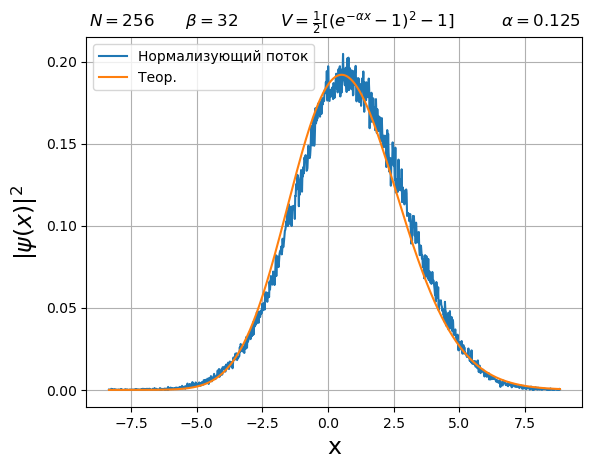

In [26]:
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure()
plt.plot(x,psi2)
plt.plot(x,morse.theor_Psi2(x))
plt.ylabel(r"$|\psi(x)|^2$",fontsize=17)
plt.xlabel("x",fontsize=17)
plt.title(r"$N=$"+str(N_nod)+"      "+r"$\beta=$"+str(Beta)+"        "+r"$V=\frac{1}{2}[(e^{-\alpha x}-1)^2-1]$"+"         "+r"$\alpha=$"+str(morse.alpha))
plt.legend(["Нормализующий поток","Теор."])
plt.grid(True)
plt.show()

In [27]:
from tqdm import tqdm
def G(X,n_p=N_nod):
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in tqdm(range(n_p)):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.roll(Y,-1,1)
    return G/(N_traj*N_nod)
g_nf=G(trajs)


100%|███████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 186.41it/s]


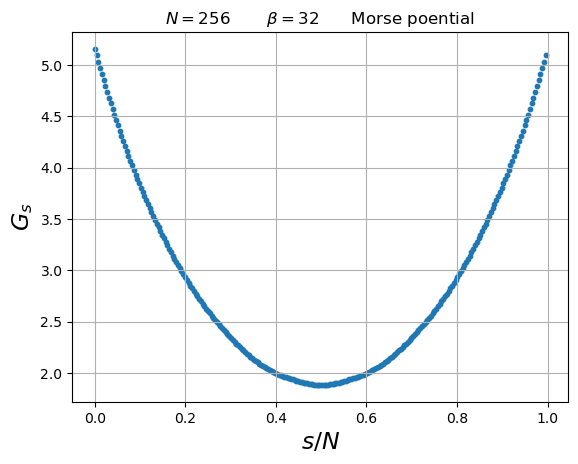

In [29]:
#import sys
#sys.path.append('../')
fig=plt.figure()
NF_list=np.arange(len(g_nf))/len(g_nf)
plt.scatter(NF_list,g_nf,s=10)
plt.title(r"$N=$"+str(N_nod)+"       "r"$\beta=$"+str(Beta)+"      Morse poential")
plt.ylabel(r"$G_s$",fontsize=17)
plt.xlabel(r"$s/N$",fontsize=17)
plt.grid(True)
plt.show()
